In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import os
from scipy.spatial import Voronoi
# for requirements: install fastparquet 

import glob # not needed in requirements

## 1. Random operations on data

### Raw data processing: removing null HO and grouping by eNB pairs

In [2]:
def get_filename(date, folder):
    dir = '..\\..\\HOCNAM_week\\HOCNAM\\' + folder + '\\' + date 
    filename = dir
    for root,dirs,files in os.walk(dir):
        for file in files:
            if file.endswith(".csv"):
                filename += '\\' + file
    return filename

In [3]:
DATE = '2024-10-28'

PATH_CELLS = get_filename(DATE, folder='cells')
PATH_HO = get_filename(DATE, folder='CSV_ho')
PATH_IMSI = get_filename(DATE, folder='CSV_nbimsi')

In [29]:
imsi_df = pd.read_csv(PATH_IMSI)
imsi_df

eci_4g      ts_utc  nb_imsi            dthr_cest
0       24723972  1730138400      510  2024-10-28 19:00:00
1       24162316  1730131200      365  2024-10-28 17:00:00
2       24304130  1730131200      937  2024-10-28 17:00:00
3       24575498  1730134800     1168  2024-10-28 18:00:00
4       24720900  1730134800     1152  2024-10-28 18:00:00
...          ...         ...      ...                  ...
814379  24639500  1730142000        2  2024-10-28 20:00:00
814380  24533768  1730077200        1  2024-10-28 02:00:00
814381  25567748  1730084400        1  2024-10-28 04:00:00
814382  25581314  1730073600        1  2024-10-28 01:00:00
814383  25566982  1730073600        1  2024-10-28 01:00:00

[814384 rows x 4 columns]

In [59]:
d = datetime.datetime(2024, 10, 28, 19, 0, 0)
print(d)

import time
utsp = time.mktime(d.timetuple())
print(utsp)

2024-10-28 19:00:00
1730138400.0


In [86]:
ho_df = pd.read_csv(PATH_HO)
ho_df

prev_eci_4g    eci_4g      ts_utc  nb_imsi  nb_ho  \
0          24450049.0  26072590  1730134800       10     10   
1          24549398.0  23996936  1730138400       43     57   
2          25038593.0  25700869  1730138400      380    386   
3          25604877.0  25428998  1730134800       13     13   
4          24067336.0  24091144  1730131200      385    398   
...               ...       ...         ...      ...    ...   
17037367   25951756.0  24085766  1730142000        1      1   
17037368   24968968.0  24517641  1730142000        1      1   
17037369   24745729.0  24269320  1730091600        1      1   
17037370   24522755.0  25898498  1730127600        1      1   
17037371   25941263.0  24528897  1730149200        1      1   

                    dthr_cest  
0         2024-10-28 18:00:00  
1         2024-10-28 19:00:00  
2         2024-10-28 19:00:00  
3         2024-10-28 18:00:00  
4         2024-10-28 17:00:00  
...                       ...  
17037367  2024-10-28 20:00:00  
17037368  2024-10-28 20:00:00  
17037369  2024-10-28 06:00:00  
17037370  2024-10-28 16:00:00  
17037371  2024-10-28 22:00:00  

[17037372 rows x 6 columns]

In [90]:
df = pd.DataFrame(ho_df.groupby(['prev_eci_4g', 'eci_4g'])[['nb_imsi','nb_ho']].sum())
df

nb_imsi  nb_ho
prev_eci_4g eci_4g                   
11343873.0  265951235        1      1
14254856.0  24417801         0      0
14256897.0  24588042         1      1
14256900.0  24967169         0      0
14349825.0  24719874         1      1
...                        ...    ...
268145155.0 24739076         0      0
            24750594         0      0
            24755714         0      0
268145411.0 24739073         0      0
268146689.0 14643202         1      1

[2472087 rows x 2 columns]

In [27]:
ho_df.dtypes

prev_eci_4g    float64
eci_4g           int64
ts_utc           int64
nb_imsi          int64
nb_ho            int64
dthr_cest       object
dtype: object

In [77]:
cells_df = pd.read_csv(PATH_CELLS) 
cells_df

eci_4g            nom_cellule couverture  azimuth  longitude  \
0      24316425  MEAUX_BEAUVAL_ENB1_H2    OUTDOOR      110   2.920664   
1      24316419  MEAUX_BEAUVAL_ENB1_E3    OUTDOOR      240   2.920664   
2      24316429  MEAUX_BEAUVAL_ENB1_V3    OUTDOOR      240   2.920664   
3      24316417  MEAUX_BEAUVAL_ENB1_E1    OUTDOOR        0   2.920664   
4      24316428  MEAUX_BEAUVAL_ENB1_V2    OUTDOOR      110   2.920664   
...         ...                    ...        ...      ...        ...   
41124  24886023   FONTENAILLES_ENB2_K1    OUTDOOR      100   2.953028   
41125  24886024   FONTENAILLES_ENB2_K2    OUTDOOR      220   2.953028   
41126  24886018   FONTENAILLES_ENB2_F2    OUTDOOR      220   2.953028   
41127  24886025   FONTENAILLES_ENB2_K3    OUTDOOR      340   2.953028   
41128  24886021   FONTENAILLES_ENB2_F3    OUTDOOR      340   2.953028   

        latitude  
0      48.952232  
1      48.952232  
2      48.952232  
3      48.952232  
4      48.952232  
...          ...  
41124  48.555122  
41125  48.555122  
41126  48.555122  
41127  48.555122  
41128  48.555122  

[41129 rows x 6 columns]

In [10]:
cells_df.dtypes

eci_4g           int64
nom_cellule     object
couverture      object
azimuth          int64
longitude      float64
latitude       float64
dtype: object

In [ ]:
# TODO: rename cells and agregate antennas by new name (same location), use later instead of eci_4g
txt = 'MEAUX_BEAUVAL_ENB1_H2'
l = txt.split('_')
'_'.join(l[0:-2])

'MEAUX_BEAUVAL'

In [79]:
cells_list = []

for id, row in cells_df.iterrows():
    prev_name = row['nom_cellule'].split('_')
    cells_list.append('_'.join(prev_name[0:-2]))
    
cells_df['Cell'] = cells_list
cells_df

eci_4g            nom_cellule couverture  azimuth  longitude  \
0      24316425  MEAUX_BEAUVAL_ENB1_H2    OUTDOOR      110   2.920664   
1      24316419  MEAUX_BEAUVAL_ENB1_E3    OUTDOOR      240   2.920664   
2      24316429  MEAUX_BEAUVAL_ENB1_V3    OUTDOOR      240   2.920664   
3      24316417  MEAUX_BEAUVAL_ENB1_E1    OUTDOOR        0   2.920664   
4      24316428  MEAUX_BEAUVAL_ENB1_V2    OUTDOOR      110   2.920664   
...         ...                    ...        ...      ...        ...   
41124  24886023   FONTENAILLES_ENB2_K1    OUTDOOR      100   2.953028   
41125  24886024   FONTENAILLES_ENB2_K2    OUTDOOR      220   2.953028   
41126  24886018   FONTENAILLES_ENB2_F2    OUTDOOR      220   2.953028   
41127  24886025   FONTENAILLES_ENB2_K3    OUTDOOR      340   2.953028   
41128  24886021   FONTENAILLES_ENB2_F3    OUTDOOR      340   2.953028   

        latitude           Cell  
0      48.952232  MEAUX_BEAUVAL  
1      48.952232  MEAUX_BEAUVAL  
2      48.952232  MEAUX_BEAUVAL  
3      48.952232  MEAUX_BEAUVAL  
4      48.952232  MEAUX_BEAUVAL  
...          ...            ...  
41124  48.555122   FONTENAILLES  
41125  48.555122   FONTENAILLES  
41126  48.555122   FONTENAILLES  
41127  48.555122   FONTENAILLES  
41128  48.555122   FONTENAILLES  

[41129 rows x 7 columns]

In [66]:
ho_df = pd.read_parquet('..\\Processed_data\\4G_HOCNAM_week.snappy.parquet', engine='fastparquet') # Paris 2024
#ho_df = ho_df.loc[ho_df.prev_eci_4g != ho_df.eci_4g]
ho_df

prev_eci_4g    eci_4g  nb_ho                   srcCell    srcLON  \
index                                                                       
688         23980801  23980801     24           VILLEDO_ENB1_E1  2.337431   
689         23980801  23983106      5           VILLEDO_ENB1_E1  2.337431   
690         23980801  23983107     54           VILLEDO_ENB1_E1  2.337431   
691         23980801  23983113      1           VILLEDO_ENB1_E1  2.337431   
692         23980801  23983361      3           VILLEDO_ENB1_E1  2.337431   
...              ...       ...    ...                       ...       ...   
3897636     26400778  26172943      1  RUE_BAGNOLET_BIS_ENB2_K2  2.399294   
3897637     26400778  26246150      3  RUE_BAGNOLET_BIS_ENB2_K2  2.399294   
3897638     26400778  26246159     19  RUE_BAGNOLET_BIS_ENB2_K2  2.399294   
3897639     26400778  26246414      1  RUE_BAGNOLET_BIS_ENB2_K2  2.399294   
3897640     26400778  26400778      8  RUE_BAGNOLET_BIS_ENB2_K2  2.399294   

            srcLAT                     dstCell    dstLON     dstLAT  
index                                                                
688      48.867230             VILLEDO_ENB1_E1  2.337431  48.867230  
689      48.867230         BOULE_ROUGE_ENB1_E2  2.344583  48.872950  
690      48.867230         BOULE_ROUGE_ENB1_E3  2.344583  48.872950  
691      48.867230         BOULE_ROUGE_ENB1_H3  2.344583  48.872950  
692      48.867230         TRINITE_BIS_ENB1_E1  2.335047  48.875404  
...            ...                         ...       ...        ...  
3897636  48.856537  PORTE_DE_MONTREUIL_ENB2_K3  2.417500  48.852920  
3897637  48.856537        MENILMONTANT_ENB2_F2  2.391297  48.866524  
3897638  48.856537        MENILMONTANT_ENB2_K2  2.391297  48.866524  
3897639  48.856537      PARMENTIER_BIS_ENB2_K2  2.380547  48.866680  
3897640  48.856537    RUE_BAGNOLET_BIS_ENB2_K2  2.399294  48.856537  

[826501 rows x 9 columns]

In [70]:
pd.DataFrame(ho_df.groupby(['srcLON', 'srcLAT','dstLON','dstLAT'])['nb_ho'].sum())

nb_ho
srcLON   srcLAT    dstLON   dstLAT           
2.248553 48.893050 2.248553 48.893050   16956
                   2.248772 48.892000    3937
                   2.248822 48.878080     157
                   2.248922 48.884388    1851
                   2.249897 48.888058       1
...                                       ...
2.418389 48.812458 2.408133 48.856000       2
                   2.410700 48.823105  207345
                   2.413614 48.869164    3206
                   2.417019 48.843113       1
                   2.418389 48.812458  135174

[55503 rows x 1 columns]

In [4]:
PATH_HO = '..\\..\\Data_Handover\\usersHandovers\\2019\\03\\16\\Lyon_HO_IN'

all_files = glob.glob(PATH_HO + "\\*.parquet")

li = []

for filename in all_files:
    df = pd.read_parquet(filename, engine='fastparquet')
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame

timeSlot        srcLocInfo        dstLocInfo  nbHO15
0       1552734000  8102f81000009986  8102f81000009991     171
1       1552753800  8102f810000099d1  8102f810000099ae    1508
2       1552757400  8102f8100000a481  8102f81000009c31     814
3       1552753800  8102f81000009de8  8102f81000009d5e     277
4       1552732200  8102f81000009952  8102f81000009975    1198
...            ...               ...               ...     ...
719641  1552759200  0002f8100704edda  0002f8100704512d       0
719642  1552759200  0002f81051100807  0002f81051053587       0
719643  1552746600  8102f8100000ba74  8102f8100000ba60       0
719644  1552770000  8102f810000099c9  8102f8100000babc       0
719645  1552734000  0002f81051109a04  0002f81051108452       0

[719646 rows x 4 columns]

In [5]:
agg = frame.groupby('timeSlot')['nbHO15'].sum()
time_df = pd.DataFrame(agg)
time_df.head()

nbHO15
timeSlot          
1552690800  321050
1552692600  238867
1552694400  202796
1552696200  146731
1552698000  125253

In [7]:
d = datetime.datetime(2019, 3, 16, 1, 0, 0)
print(d)

import time
utsp = time.mktime(d.timetuple())
print(utsp)

2019-03-16 01:00:00
1552694400.0


In [6]:
ser = pd.Series()
for idx,row in time_df.iterrows():
    ser[idx] = datetime.datetime.fromtimestamp(row.name)
time_df['Time'] = ser
time_df

nbHO15                Time
timeSlot                               
1552690800   321050 2019-03-16 00:00:00
1552692600   238867 2019-03-16 00:30:00
1552694400   202796 2019-03-16 01:00:00
1552696200   146731 2019-03-16 01:30:00
1552698000   125253 2019-03-16 02:00:00
1552699800   113050 2019-03-16 02:30:00
1552701600   106047 2019-03-16 03:00:00
1552703400   106442 2019-03-16 03:30:00
1552705200   105907 2019-03-16 04:00:00
1552707000   107803 2019-03-16 04:30:00
1552708800   122374 2019-03-16 05:00:00
1552710600   143007 2019-03-16 05:30:00
1552712400   153162 2019-03-16 06:00:00
1552714200   174321 2019-03-16 06:30:00
1552716000   268179 2019-03-16 07:00:00
1552717800   367263 2019-03-16 07:30:00
1552719600   483937 2019-03-16 08:00:00
1552721400   648755 2019-03-16 08:30:00
1552723200   821730 2019-03-16 09:00:00
1552725000   921528 2019-03-16 09:30:00
1552726800  1064546 2019-03-16 10:00:00
1552728600  1196273 2019-03-16 10:30:00
1552730400  1213236 2019-03-16 11:00:00
1552732200  1187904 2019-03-16 11:30:00
1552734000  1184252 2019-03-16 12:00:00
1552735800  1087754 2019-03-16 12:30:00
1552737600  1012628 2019-03-16 13:00:00
1552739400  1034287 2019-03-16 13:30:00
1552741200  1072032 2019-03-16 14:00:00
1552743000  1142220 2019-03-16 14:30:00
1552744800  1164714 2019-03-16 15:00:00
1552746600  1189759 2019-03-16 15:30:00
1552748400  1181775 2019-03-16 16:00:00
1552750200  1159496 2019-03-16 16:30:00
1552752000  1141190 2019-03-16 17:00:00
1552753800  1147550 2019-03-16 17:30:00
1552755600  1157564 2019-03-16 18:00:00
1552757400  1170255 2019-03-16 18:30:00
1552759200  1148782 2019-03-16 19:00:00
1552761000  1020806 2019-03-16 19:30:00
1552762800   833722 2019-03-16 20:00:00
1552764600   652147 2019-03-16 20:30:00
1552766400   523090 2019-03-16 21:00:00
1552768200   469287 2019-03-16 21:30:00
1552770000   429009 2019-03-16 22:00:00
1552771800   393491 2019-03-16 22:30:00
1552773600   384531 2019-03-16 23:00:00
1552775400   365814 2019-03-16 23:30:00

In [7]:
agg = frame.groupby(['srcLocInfo', 'dstLocInfo'])['nbHO15'].sum()
df_agg = pd.DataFrame(agg)
df_agg = df_agg[df_agg['nbHO15'] >0] 
#agg = agg.drop(agg.loc[agg.values==0].index)
#agg
df_agg

nbHO15
srcLocInfo       dstLocInfo              
0002f81000686160 0002f81007013bfa      26
0002f810041c2388 0002f81007041283      16
0002f81007011463 0002f8100701fe3f      31
0002f81007011465 0002f810070126d7      17
0002f810070114de 0002f81007013336    1240
...                                   ...
8102f8100000bad0 8102f8100000a1fa     515
                 8102f8100000a4d9      57
                 8102f8100000b9cc    5924
                 8102f8100000ba30     189
                 8102f8100000babe     184

[11700 rows x 1 columns]

## Processing aggregated data

In [92]:
#PATH_HO = '..\\Processed_data\\4G_CSV_ho_AGG_week.snappy.parquet'
PATH_HO = '..\\Processed_data\\4G_CSV_ho_AGG_2024-10-28.snappy.parquet'
PATH_CELLS = '..\\Processed_data\\4G_cells_AGG_week.snappy.parquet'

In [125]:
ho_df = pd.read_parquet(path=PATH_HO, engine='fastparquet')
ho_df

prev_eci_4g     eci_4g  nb_imsi  nb_ho
0           11343873  265951235        1      1
1           14256897   24588042        1      1
2           14349825   24719874        1      1
3           14349825   25514757        2      2
4           14352645   24478727        1      1
...              ...        ...      ...    ...
2409257    267841030  267745545       15     15
2409258    267841030  267841028        7      7
2409259    267841030  267841029        9      9
2409260    267841030  267841030      171    182
2409261    268146689   14643202        1      1

[2409262 rows x 4 columns]

In [126]:
cells_df = pd.read_parquet(path=PATH_CELLS, engine='fastparquet')
cells_df

eci_4g            nom_cellule couverture  azimuth  longitude  \
0      24316425  MEAUX_BEAUVAL_ENB1_H2    OUTDOOR      110   2.920664   
1      24316419  MEAUX_BEAUVAL_ENB1_E3    OUTDOOR      240   2.920664   
2      24316429  MEAUX_BEAUVAL_ENB1_V3    OUTDOOR      240   2.920664   
3      24316417  MEAUX_BEAUVAL_ENB1_E1    OUTDOOR        0   2.920664   
4      24316428  MEAUX_BEAUVAL_ENB1_V2    OUTDOOR      110   2.920664   
...         ...                    ...        ...      ...        ...   
41289  24527366      ROISSY_T1_ENB1_H2     INDOOR       40   2.541550   
41290  24527371      ROISSY_T1_ENB1_V3     INDOOR       80   2.541550   
41291  24527369      ROISSY_T1_ENB1_E2     INDOOR       40   2.541550   
41292  24527365      ROISSY_T1_ENB1_H3     INDOOR       80   2.541550   
41293  24527372      ROISSY_T1_ENB1_V2     INDOOR       40   2.541550   

        latitude           Cell  
0      48.952232  MEAUX_BEAUVAL  
1      48.952232  MEAUX_BEAUVAL  
2      48.952232  MEAUX_BEAUVAL  
3      48.952232  MEAUX_BEAUVAL  
4      48.952232  MEAUX_BEAUVAL  
...          ...            ...  
41289  49.014233      ROISSY_T1  
41290  49.014233      ROISSY_T1  
41291  49.014233      ROISSY_T1  
41292  49.014233      ROISSY_T1  
41293  49.014233      ROISSY_T1  

[41294 rows x 7 columns]

In [84]:
cells_df.loc[cells_df.Cell=='MEAUX_BEAUVAL']

eci_4g            nom_cellule couverture  azimuth  longitude  \
0      24316425  MEAUX_BEAUVAL_ENB1_H2    OUTDOOR      110   2.920664   
1      24316419  MEAUX_BEAUVAL_ENB1_E3    OUTDOOR      240   2.920664   
2      24316429  MEAUX_BEAUVAL_ENB1_V3    OUTDOOR      240   2.920664   
3      24316417  MEAUX_BEAUVAL_ENB1_E1    OUTDOOR        0   2.920664   
4      24316428  MEAUX_BEAUVAL_ENB1_V2    OUTDOOR      110   2.920664   
5      24316426  MEAUX_BEAUVAL_ENB1_H3    OUTDOOR      240   2.920664   
6      24316424  MEAUX_BEAUVAL_ENB1_H1    OUTDOOR        0   2.920664   
7      24316427  MEAUX_BEAUVAL_ENB1_V1    OUTDOOR        0   2.920664   
8      24316418  MEAUX_BEAUVAL_ENB1_E2    OUTDOOR      110   2.920664   
33374  24316422  MEAUX_BEAUVAL_ENB2_F2    OUTDOOR      110   2.920664   
33375  24316421  MEAUX_BEAUVAL_ENB2_F1    OUTDOOR        0   2.920664   
33376  24316423  MEAUX_BEAUVAL_ENB2_F3    OUTDOOR      240   2.920664   

        latitude           Cell  
0      48.952232  MEAUX_BEAUVAL  
1      48.952232  MEAUX_BEAUVAL  
2      48.952232  MEAUX_BEAUVAL  
3      48.952232  MEAUX_BEAUVAL  
4      48.952232  MEAUX_BEAUVAL  
5      48.952232  MEAUX_BEAUVAL  
6      48.952232  MEAUX_BEAUVAL  
7      48.952232  MEAUX_BEAUVAL  
8      48.952232  MEAUX_BEAUVAL  
33374  48.952232  MEAUX_BEAUVAL  
33375  48.952232  MEAUX_BEAUVAL  
33376  48.952232  MEAUX_BEAUVAL

In [127]:
ho_df = ho_df.join(cells_df[['eci_4g','Cell']].set_index('eci_4g'), on='prev_eci_4g')
ho_df.rename(columns={'Cell':'srcCell'}, inplace=True)
ho_df = ho_df.dropna(ignore_index=True)

ho_df = ho_df.join(cells_df[['eci_4g','Cell']].set_index('eci_4g'), on='eci_4g')
ho_df.rename(columns={'Cell':'dstCell'}, inplace=True)
ho_df = ho_df.dropna(ignore_index=True)

ho_df

prev_eci_4g     eci_4g  nb_imsi  nb_ho             srcCell  \
0           14643201   14643201      711    713       AUNAY_TGV_BIS   
1           14643201   14643202      902    903       AUNAY_TGV_BIS   
2           14643201   14643204      147    147       AUNAY_TGV_BIS   
3           14643201   14643205      136    136       AUNAY_TGV_BIS   
4           14643201   14643207       93     93       AUNAY_TGV_BIS   
...              ...        ...      ...    ...                 ...   
2389099    267841030  267745544        7      7  ND_RS_LECHELLE_ORF   
2389100    267841030  267745545       15     15  ND_RS_LECHELLE_ORF   
2389101    267841030  267841028        7      7  ND_RS_LECHELLE_ORF   
2389102    267841030  267841029        9      9  ND_RS_LECHELLE_ORF   
2389103    267841030  267841030      171    182  ND_RS_LECHELLE_ORF   

                    dstCell  
0             AUNAY_TGV_BIS  
1             AUNAY_TGV_BIS  
2             AUNAY_TGV_BIS  
3             AUNAY_TGV_BIS  
4             AUNAY_TGV_BIS  
...                     ...  
2389099  ND_RS_LECHELLE_ORF  
2389100  ND_RS_LECHELLE_ORF  
2389101  ND_RS_LECHELLE_ORF  
2389102  ND_RS_LECHELLE_ORF  
2389103  ND_RS_LECHELLE_ORF  

[2389104 rows x 6 columns]

In [128]:
# Group by cell name (antennas located at the same point)
ho_df = ho_df.groupby(['srcCell','dstCell'])[['nb_imsi','nb_ho']].sum()
ho_df = ho_df.reset_index()
ho_df 

srcCell                       dstCell  nb_imsi  \
0       A12_TRIANGLE_DE_ROCQUENCOURT  A12_TRIANGLE_DE_ROCQUENCOURT       23   
1       A12_TRIANGLE_DE_ROCQUENCOURT                    BEYNES_BIS        1   
2       A12_TRIANGLE_DE_ROCQUENCOURT                   BEYNES_D119        1   
3       A12_TRIANGLE_DE_ROCQUENCOURT                    BEYNES_TDB        1   
4       A12_TRIANGLE_DE_ROCQUENCOURT     BOIS_D_ARCY_CROIX_BLANCHE       17   
...                              ...                           ...      ...   
184932                 ZENITH_INDOOR               PORTE_DES_LILAS        1   
184933                 ZENITH_INDOOR                QUATRE_CHEMINS        2   
184934                 ZENITH_INDOOR               RUE_DE_TOULOUSE        8   
184935                 ZENITH_INDOOR              STADE_LADOUMEGUE       13   
184936                 ZENITH_INDOOR                    STALINGRAD       84   

        nb_ho  
0          23  
1           1  
2           1  
3           1  
4          17  
...       ...  
184932      1  
184933      2  
184934     12  
184935     21  
184936     89  

[184937 rows x 4 columns]

In [129]:
agg_cells_df = cells_df.groupby('Cell', group_keys=True)[['longitude','latitude']].mean()
agg_cells_df = agg_cells_df.reset_index()
agg_cells_df

Cell  longitude   latitude
0     A12_TRIANGLE_DE_ROCQUENCOURT   2.093986  48.842075
1               ABBESSES_METRO_L12   2.338358  48.884530
2                   ABBESSES_MICRO   2.338767  48.883987
3             ABBEVILLE_LA_RIVIERE   2.193303  48.356170
4                   ABBE_ROUSSELOT   2.302803  48.888523
...                            ...        ...        ...
4068          YERRES_BOUT_DU_MONDE   2.510731  48.709293
4069     YERRES_LES_GRANDS_GODEAUX   2.500569  48.716667
4070             YERRES_LE_TAILLIS   2.480614  48.696434
4071                 ZAC_DES_LILAS   2.408325  48.877020
4072                 ZENITH_INDOOR   2.393206  48.894215

[4073 rows x 3 columns]

### Joining src and dst coordinates

In [130]:
# Add src EnB coordinates
ho_df = ho_df.join(agg_cells_df[['Cell','longitude','latitude']].set_index('Cell'), on='srcCell')
ho_df.rename(columns={'Cell':'srcCell','longitude':'srcLON', 'latitude':'srcLAT'}, inplace=True)
ho_df = ho_df.dropna(ignore_index=True)

# Add dst EnB coordinates
ho_df = ho_df.join(agg_cells_df[['Cell','longitude','latitude']].set_index('Cell'), on='dstCell')
ho_df.rename(columns={'Cell':'dstCell','longitude':'dstLON', 'latitude':'dstLAT'}, inplace=True)
ho_df = ho_df.dropna(ignore_index=True)
ho_df

srcCell                       dstCell  nb_imsi  \
0       A12_TRIANGLE_DE_ROCQUENCOURT  A12_TRIANGLE_DE_ROCQUENCOURT       23   
1       A12_TRIANGLE_DE_ROCQUENCOURT                    BEYNES_BIS        1   
2       A12_TRIANGLE_DE_ROCQUENCOURT                   BEYNES_D119        1   
3       A12_TRIANGLE_DE_ROCQUENCOURT                    BEYNES_TDB        1   
4       A12_TRIANGLE_DE_ROCQUENCOURT     BOIS_D_ARCY_CROIX_BLANCHE       17   
...                              ...                           ...      ...   
184932                 ZENITH_INDOOR               PORTE_DES_LILAS        1   
184933                 ZENITH_INDOOR                QUATRE_CHEMINS        2   
184934                 ZENITH_INDOOR               RUE_DE_TOULOUSE        8   
184935                 ZENITH_INDOOR              STADE_LADOUMEGUE       13   
184936                 ZENITH_INDOOR                    STALINGRAD       84   

        nb_ho    srcLON     srcLAT    dstLON     dstLAT  
0          23  2.093986  48.842075  2.093986  48.842075  
1           1  2.093986  48.842075  1.872747  48.845040  
2           1  2.093986  48.842075  1.857706  48.859165  
3           1  2.093986  48.842075  1.900411  48.837810  
4          17  2.093986  48.842075  2.010703  48.797540  
...       ...       ...        ...       ...        ...  
184932      1  2.393206  48.894215  2.400011  48.885555  
184933      2  2.393206  48.894215  2.394108  48.909058  
184934     12  2.393206  48.894215  2.393536  48.883896  
184935     21  2.393206  48.894215  2.393008  48.888416  
184936     89  2.393206  48.894215  2.383208  48.887360  

[184937 rows x 8 columns]

In [131]:
ho_df.to_parquet('..\\Processed_data\\4G_CSV_ho_AGG_2024-10-28_coords.snappy.parquet', engine='fastparquet', compression='snappy')

In [120]:
ho_df.dtypes

srcCell     object
dstCell     object
nb_imsi      int64
nb_ho        int64
srcLON     float64
srcLAT     float64
dstLON     float64
dstLAT     float64
dtype: object

### Reducing to geographic zone of interest

In [132]:
lon1, lat1 = 2.248553, 48.89305
lon2, lat2 = 2.418389, 48.812458

In [133]:
# Reduce by source and dst coords
ho_df = ho_df.loc[(ho_df['srcLON'] >= lon1) & (ho_df['srcLON'] <= lon2) & (ho_df['srcLAT'] >= lat2) & (ho_df['srcLAT'] <= lat1)]
ho_df = ho_df.loc[(ho_df['dstLON'] >= lon1) & (ho_df['dstLON'] <= lon2) & (ho_df['dstLAT'] >= lat2) & (ho_df['dstLAT'] <= lat1)]
ho_df

srcCell                          dstCell  nb_imsi  nb_ho  \
65      ABBESSES_METRO_L12                   ABBESSES_MICRO      688    695   
67      ABBESSES_METRO_L12          JULES_JOFFRIN_METRO_L12       11     12   
68      ABBESSES_METRO_L12   LAMARCK_CAULAINCOURT_METRO_L12     3414   3414   
69      ABBESSES_METRO_L12             ST_GEORGES_METRO_L12       15     23   
70          ABBESSES_MICRO               ABBESSES_METRO_L12      446    449   
...                    ...                              ...      ...    ...   
184919       ZAC_DES_LILAS                   ST_FARGEAU_IDF     1320   1394   
184920       ZAC_DES_LILAS                       TELEGRAPHE       31     47   
184921       ZAC_DES_LILAS               TPIM_PTE_DES_LILAS    14063  14439   
184922       ZAC_DES_LILAS  TPIM_SQUARE_FLEURY_FOUGERES_BIS     2526   2533   
184924       ZAC_DES_LILAS                    ZAC_DES_LILAS     2220   2806   

          srcLON     srcLAT    dstLON     dstLAT  
65      2.338358  48.884530  2.338767  48.883987  
67      2.338358  48.884530  2.344628  48.892544  
68      2.338358  48.884530  2.338700  48.889874  
69      2.338358  48.884530  2.337717  48.878418  
70      2.338767  48.883987  2.338358  48.884530  
...          ...        ...       ...        ...  
184919  2.408325  48.877020  2.408414  48.871387  
184920  2.408325  48.877020  2.397586  48.875732  
184921  2.408325  48.877020  2.408450  48.878270  
184922  2.408325  48.877020  2.412189  48.873013  
184924  2.408325  48.877020  2.408325  48.877020  

[40289 rows x 8 columns]

In [134]:
ho_df.to_parquet('..\\Processed_data\\4G_CSV_ho_AGG_2024-10-28_coords_Paris.snappy.parquet', engine='fastparquet', compression='snappy')

In [135]:
ho_df = pd.read_parquet('..\\Processed_data\\4G_CSV_ho_AGG_2024-10-28_coords.snappy.parquet', engine='fastparquet')
ho_df

srcCell                       dstCell  nb_imsi  \
0       A12_TRIANGLE_DE_ROCQUENCOURT  A12_TRIANGLE_DE_ROCQUENCOURT       23   
1       A12_TRIANGLE_DE_ROCQUENCOURT                    BEYNES_BIS        1   
2       A12_TRIANGLE_DE_ROCQUENCOURT                   BEYNES_D119        1   
3       A12_TRIANGLE_DE_ROCQUENCOURT                    BEYNES_TDB        1   
4       A12_TRIANGLE_DE_ROCQUENCOURT     BOIS_D_ARCY_CROIX_BLANCHE       17   
...                              ...                           ...      ...   
184932                 ZENITH_INDOOR               PORTE_DES_LILAS        1   
184933                 ZENITH_INDOOR                QUATRE_CHEMINS        2   
184934                 ZENITH_INDOOR               RUE_DE_TOULOUSE        8   
184935                 ZENITH_INDOOR              STADE_LADOUMEGUE       13   
184936                 ZENITH_INDOOR                    STALINGRAD       84   

        nb_ho    srcLON     srcLAT    dstLON     dstLAT  
0          23  2.093986  48.842075  2.093986  48.842075  
1           1  2.093986  48.842075  1.872747  48.845040  
2           1  2.093986  48.842075  1.857706  48.859165  
3           1  2.093986  48.842075  1.900411  48.837810  
4          17  2.093986  48.842075  2.010703  48.797540  
...       ...       ...        ...       ...        ...  
184932      1  2.393206  48.894215  2.400011  48.885555  
184933      2  2.393206  48.894215  2.394108  48.909058  
184934     12  2.393206  48.894215  2.393536  48.883896  
184935     21  2.393206  48.894215  2.393008  48.888416  
184936     89  2.393206  48.894215  2.383208  48.887360  

[184937 rows x 8 columns]

In [138]:
def create_map():
    map = folium.Map([48.854816, 2.347061], tiles="OpenStreetMap", zoom_start=13)
    print('Creating base station map...')
    return map

def add_stations(map, df, type='ho', name='4G stations'):
    print('Adding '+name+' layer')
    fg = folium.FeatureGroup(name=name) # Name as it will appear in Layer control
    if type=='ho':
        enb_ids = df.srcCell.unique()
        for id in enb_ids:
            enb_data = df.loc[df['srcCell']==id]
            fg.add_child(folium.CircleMarker(
                location=[enb_data['srcLAT'].iloc[-1], enb_data['srcLON'].iloc[-1]],
                tooltip=enb_data['srcCell'].iloc[-1],
                color='black',
                weight=1,
                fill=True,
                fill_color='blue',
                fill_opacity=0.9,
                radius=2
            ))
    if type=='enb':
        enb_ids = df.LocInfo.tolist()
        for id in enb_ids:
            enb_data = df.loc[df['LocInfo']==id]
            fg.add_child(folium.Marker(
                location=[enb_data['LAT'].iloc[-1], enb_data['LON'].iloc[-1]],
                popup=enb_data['LocInfo'].iloc[-1],
            ))
    map.add_child(fg)
    
    
def close_map(map, filename):
    folium.LayerControl().add_to(map)
    map.save('maps\\'+filename)
    print('Closing', filename, 'map.')

In [139]:
hocnam = create_map()
folium.TileLayer('CartoDB Positron').add_to(hocnam)
add_stations(hocnam, ho_df)
hocnam

Creating base station map...
Adding 4G stations layer


In [140]:
close_map(hocnam, 'HOCNAM_stations_IDF.html')

Closing HOCNAM_stations_IDF.html map.


## Traffic visualization

### Temporal analysis: IMSI

In [142]:
DATE = '2024-10-28'
PATH_IMSI = get_filename(DATE, folder='CSV_nbimsi')

In [4]:
imsi_df = pd.read_csv(PATH_IMSI)
imsi_df

eci_4g      ts_utc  nb_imsi            dthr_cest
0       24723972  1730138400      510  2024-10-28 19:00:00
1       24162316  1730131200      365  2024-10-28 17:00:00
2       24304130  1730131200      937  2024-10-28 17:00:00
3       24575498  1730134800     1168  2024-10-28 18:00:00
4       24720900  1730134800     1152  2024-10-28 18:00:00
...          ...         ...      ...                  ...
814379  24639500  1730142000        2  2024-10-28 20:00:00
814380  24533768  1730077200        1  2024-10-28 02:00:00
814381  25567748  1730084400        1  2024-10-28 04:00:00
814382  25581314  1730073600        1  2024-10-28 01:00:00
814383  25566982  1730073600        1  2024-10-28 01:00:00

[814384 rows x 4 columns]

In [5]:
imsi_df = imsi_df.join(cells_df[['eci_4g','Cell','longitude','latitude']].set_index('eci_4g'), on='eci_4g')
imsi_df.rename(columns={'longitude':'LON', 'latitude':'LAT'}, inplace=True)
imsi_df = imsi_df.dropna(ignore_index=True)
imsi_df

NameError: name 'cells_df' is not defined

In [148]:
imsi_df.dthr_cest = pd.to_datetime(imsi_df.dthr_cest, format="%Y-%m-%d %H:%M:%S")

In [150]:
imsi_df = imsi_df.sort_values(by='dthr_cest')
imsi_df

eci_4g      ts_utc  nb_imsi           dthr_cest  \
296562   24584977  1730070000       18 2024-10-28 00:00:00   
267949   24827137  1730070000       44 2024-10-28 00:00:00   
267948   25866241  1730070000      192 2024-10-28 00:00:00   
267947   25165328  1730070000        9 2024-10-28 00:00:00   
267946   25660417  1730070000      203 2024-10-28 00:00:00   
...           ...         ...      ...                 ...   
619284   24682497  1730152800        7 2024-10-28 23:00:00   
619280  264334956  1730152800        5 2024-10-28 23:00:00   
202008   24620803  1730152800      205 2024-10-28 23:00:00   
201993   24654338  1730152800       94 2024-10-28 23:00:00   
297285   25857543  1730152800       13 2024-10-28 23:00:00   

                              Cell       LON        LAT  
296562       BURES_FAC_DE_SCIENCES  2.172269  48.703970  
267949               LA_PLANCHETTE  3.052317  48.777412  
267948                        CELY  2.541767  48.467780  
267947           BTSH_MURAT_08_IND  2.256583  48.846897  
267946          PONT_DE_CHATOU_TER  2.169675  48.889507  
...                            ...       ...        ...  
619284       FORET_D_ARMAINVILLIER  2.700503  48.759007  
619280        ND_RS_GUILLERVAL_SFR  2.083917  48.358410  
202008       CHOISY_HOTEL_DE_VILLE  2.410644  48.763550  
201993  MONTIGNY_LE_BRETONNEUX_BIS  2.043794  48.769970  
297285               MAINCY_CENTRE  2.694767  48.557808  

[814630 rows x 7 columns]

In [174]:
smin, smed, smax = int(imsi_df.nb_imsi.min()), int(imsi_df.nb_imsi.median()), int(imsi_df.nb_imsi.max())

imsi_df['traffic_part'] = (imsi_df.nb_imsi - smin)/(smax-smin)
imsi_df

eci_4g      ts_utc  nb_imsi           dthr_cest  \
296562   24584977  1730070000       18 2024-10-28 00:00:00   
267949   24827137  1730070000       44 2024-10-28 00:00:00   
267948   25866241  1730070000      192 2024-10-28 00:00:00   
267947   25165328  1730070000        9 2024-10-28 00:00:00   
267946   25660417  1730070000      203 2024-10-28 00:00:00   
...           ...         ...      ...                 ...   
619284   24682497  1730152800        7 2024-10-28 23:00:00   
619280  264334956  1730152800        5 2024-10-28 23:00:00   
202008   24620803  1730152800      205 2024-10-28 23:00:00   
201993   24654338  1730152800       94 2024-10-28 23:00:00   
297285   25857543  1730152800       13 2024-10-28 23:00:00   

                              Cell       LON        LAT  traffic_part  
296562       BURES_FAC_DE_SCIENCES  2.172269  48.703970      0.002116  
267949               LA_PLANCHETTE  3.052317  48.777412      0.005172  
267948                        CELY  2.541767  48.467780      0.022567  
267947           BTSH_MURAT_08_IND  2.256583  48.846897      0.001058  
267946          PONT_DE_CHATOU_TER  2.169675  48.889507      0.023860  
...                            ...       ...        ...           ...  
619284       FORET_D_ARMAINVILLIER  2.700503  48.759007      0.000823  
619280        ND_RS_GUILLERVAL_SFR  2.083917  48.358410      0.000588  
202008       CHOISY_HOTEL_DE_VILLE  2.410644  48.763550      0.024095  
201993  MONTIGNY_LE_BRETONNEUX_BIS  2.043794  48.769970      0.011048  
297285               MAINCY_CENTRE  2.694767  48.557808      0.001528  

[814630 rows x 8 columns]

In [6]:
#imsi_df.to_parquet('..\\Processed_data\\4G_CSV_nbimsi_2024-10-28_coords_IDF.snappy.parquet', engine='fastparquet', compression='snappy')

imsi_df = pd.read_parquet('..\\Processed_data\\4G_CSV_nbimsi_2024-10-28_coords_IDF.snappy.parquet', engine='fastparquet')
imsi_df

eci_4g      ts_utc  nb_imsi           dthr_cest  \
index                                                        
296562   24584977  1730070000       18 2024-10-28 00:00:00   
267949   24827137  1730070000       44 2024-10-28 00:00:00   
267948   25866241  1730070000      192 2024-10-28 00:00:00   
267947   25165328  1730070000        9 2024-10-28 00:00:00   
267946   25660417  1730070000      203 2024-10-28 00:00:00   
...           ...         ...      ...                 ...   
619284   24682497  1730152800        7 2024-10-28 23:00:00   
619280  264334956  1730152800        5 2024-10-28 23:00:00   
202008   24620803  1730152800      205 2024-10-28 23:00:00   
201993   24654338  1730152800       94 2024-10-28 23:00:00   
297285   25857543  1730152800       13 2024-10-28 23:00:00   

                              Cell       LON        LAT  traffic_part  
index                                                                  
296562       BURES_FAC_DE_SCIENCES  2.172269  48.703970      0.002116  
267949               LA_PLANCHETTE  3.052317  48.777412      0.005172  
267948                        CELY  2.541767  48.467780      0.022567  
267947           BTSH_MURAT_08_IND  2.256583  48.846897      0.001058  
267946          PONT_DE_CHATOU_TER  2.169675  48.889507      0.023860  
...                            ...       ...        ...           ...  
619284       FORET_D_ARMAINVILLIER  2.700503  48.759007      0.000823  
619280        ND_RS_GUILLERVAL_SFR  2.083917  48.358410      0.000588  
202008       CHOISY_HOTEL_DE_VILLE  2.410644  48.763550      0.024095  
201993  MONTIGNY_LE_BRETONNEUX_BIS  2.043794  48.769970      0.011048  
297285               MAINCY_CENTRE  2.694767  48.557808      0.001528  

[814630 rows x 8 columns]

In [7]:
import branca
import branca.colormap as cm
from folium.plugins import HeatMap, HeatMapWithTime

In [8]:
def add_voronoi(map, points, colormap):
    print('Adding Voronoi layer')
    vor = Voronoi(list(zip(points['LAT'].tolist(), points['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name='Voronoi cells', show=True)
    for enb, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        cell_locinfo = points.Cell.iloc[enb]
        if -1 not in region and region != []:
            region_coords = []
            for vertex in region:
                region_coords.append(vor.vertices[vertex])
            score = points.loc[points.Cell==cell_locinfo, 'nb_imsi'].iloc[0]
            fg.add_child(folium.Polygon(
                region_coords,
                color="darkgray",
                weight=1,
                fill_color=colormap(score),
                fill_opacity=0.3,
                fill=True,
                tooltip=score
            ))
    map.add_child(fg)
    map.add_child(colormap)

In [9]:
time = datetime.datetime(2024, 10, 28, 0, 0, 0)
df = imsi_df.loc[imsi_df.dthr_cest==time]
df

eci_4g      ts_utc  nb_imsi  dthr_cest                         Cell  \
index                                                                           
296562  24584977  1730070000       18 2024-10-28        BURES_FAC_DE_SCIENCES   
267949  24827137  1730070000       44 2024-10-28                LA_PLANCHETTE   
267948  25866241  1730070000      192 2024-10-28                         CELY   
267947  25165328  1730070000        9 2024-10-28            BTSH_MURAT_08_IND   
267946  25660417  1730070000      203 2024-10-28           PONT_DE_CHATOU_TER   
...          ...         ...      ...        ...                          ...   
381279  24148737  1730070000      107 2024-10-28              COURBEVOIE_D908   
806506  24448013  1730070000        2 2024-10-28         SAVIGNY_SR_ORGE_D177   
380911  24574469  1730070000       59 2024-10-28           RIS_ORANGIS_MARCHE   
435532  25958923  1730070000       31 2024-10-28             GUYANCOURT_ETANG   
16186   24385032  1730070000        7 2024-10-28  BARBEY_LA_COLLERETTE_TGV_SE   

             LON        LAT  traffic_part  
index                                      
296562  2.172269  48.703970      0.002116  
267949  3.052317  48.777412      0.005172  
267948  2.541767  48.467780      0.022567  
267947  2.256583  48.846897      0.001058  
267946  2.169675  48.889507      0.023860  
...          ...        ...           ...  
381279  2.255806  48.901333      0.012576  
806506  2.363244  48.673508      0.000235  
380911  2.404489  48.660492      0.006935  
435532  2.073444  48.774227      0.003644  
16186   3.053608  48.372820      0.000823  

[38102 rows x 8 columns]

In [158]:
# Reduce by source and dst coords
df = df.loc[(df['LON'] >= lon1) & (df['LON'] <= lon2) & (df['LAT'] >= lat2) & (df['LAT'] <= lat1)]
df

eci_4g      ts_utc  nb_imsi           dthr_cest  \
797420  24341773  1730091600      108 2024-10-28 06:00:00   
422873  24526085  1730091600       29 2024-10-28 06:00:00   
316913  24001034  1730091600      214 2024-10-28 06:00:00   
17357   25315847  1730091600     1264 2024-10-28 06:00:00   
139990  25057538  1730091600      676 2024-10-28 06:00:00   
...          ...         ...      ...                 ...   
373902  24243976  1730091600      224 2024-10-28 06:00:00   
222689  24011530  1730091600      133 2024-10-28 06:00:00   
227819  24333579  1730091600       11 2024-10-28 06:00:00   
48484   24371207  1730091600      105 2024-10-28 06:00:00   
280983  24461579  1730091600        5 2024-10-28 06:00:00   

                                        Cell       LON        LAT  
797420                       PONT_DE_PUTEAUX  2.248822  48.878080  
422873         PALAIS_DES_CONGRES_INDOOR_IDF  2.283678  48.879234  
316913                             LE_PONANT  2.271206  48.839340  
17357           GARE_MONTPARNASSE_INDOOR_BIS  2.315225  48.838240  
139990              TPEM_PONT_DE_NEUILLY_CDG  2.258608  48.885310  
...                                      ...       ...        ...  
373902                          RUE_SAUSSURE  2.312575  48.883564  
222689                               BASSANO  2.296917  48.868470  
227819  OSM_CREDIT_AGRICOLE_MONTROUGE_INDOOR  2.312525  48.817670  
48484                       PORT_ROYAL_RER_B  2.337008  48.839832  
280983                     ST_MANDE_METRO_L1  2.417461  48.846546  

[9351 rows x 7 columns]

{'whiskers': [<matplotlib.lines.Line2D at 0x26b26eb0610>,
 'caps': [<matplotlib.lines.Line2D at 0x26b26ea4fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x26b26eb06d0>],
 'medians': [<matplotlib.lines.Line2D at 0x26b26ea4280>],
 'fliers': [<matplotlib.lines.Line2D at 0x26b26ea4d00>],
 'means': []}

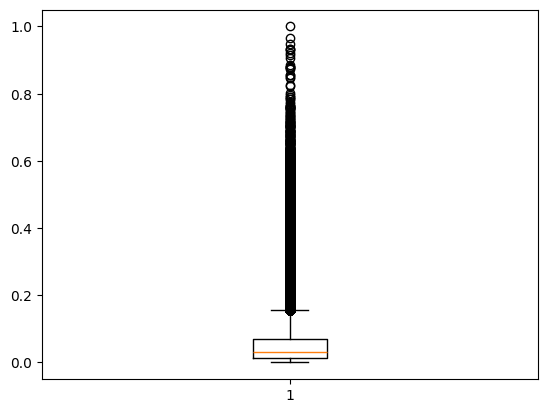

In [199]:
heat_data = [[row['LAT'],row['LON'], row['traffic_part']] for idx, row in imsi_df.iterrows()]
plt.boxplot(imsi_df.traffic_part)

In [196]:
help(HeatMapWithTime)

Help on class HeatMapWithTime in module folium.plugins.heat_map_withtime:

class HeatMapWithTime(folium.elements.JSCSSMixin, folium.map.Layer)
 |  HeatMapWithTime(data, index=None, name=None, radius=15, blur=0.8, min_opacity=0, max_opacity=0.6, scale_radius=False, gradient=None, use_local_extrema=False, auto_play=False, display_index=True, index_steps=1, min_speed=0.1, max_speed=10, speed_step=0.1, position='bottomleft', overlay=True, control=True, show=True)
 |  
 |  Create a HeatMapWithTime layer
 |  
 |  Parameters
 |  ----------
 |  data: list of list of points of the form [lat, lng] or [lat, lng, weight]
 |      The points you want to plot. The outer list corresponds to the various time
 |      steps in sequential order. (weight is in (0, 1] range and defaults to 1 if
 |      not specified for a point)
 |  index: Index giving the label (or timestamp) of the elements of data. Should have
 |      the same length as data, or is replaced by a simple count if not specified.
 |  name : 

In [ ]:
data = [[row['LAT'],row['LON']] for idx, row in imsi_df.iterrows()]

In [10]:
tsp = list(imsi_df.dthr_cest)
data = [list(imsi_df.loc[imsi_df.dthr_cest==t][['LAT','LON','traffic_part']].values.tolist()) for t in tsp]
data

MemoryError: Unable to allocate 893. KiB for an array with shape (3, 38102) and data type float64

In [ ]:
hocnam = create_map()
folium.TileLayer('CartoDB Positron').add_to(hocnam)

HeatMapWithTime(
    data = data, 
    #index = list(imsi_df.dthr_cest), 
    radius=10).add_to(hocnam)

close_map(hocnam, 'HOCNAM_IMSI_IDF_timelapse.html')
hocnam

Creating base station map...
Closing HOCNAM_IMSI_IDF_timelapse.html map.
